This Chapter of the book is all about Fully Connected Networks. First, a linear regression Model is build. Second, a logistic regression is build.

In [20]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # imports command line progressbar
from torch.utils.data import * 
# from idlmam import * # github package to the book


In [4]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device='cpu'):
    # training_loader provides us with a batched dataset, which omits having the dataset stored in memory all the time.
    # initialize optimizer with model params
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # move model to devide
    model.to(device)

    # do the training
    for epoch in tqdm(range(epochs), desc = "Epoch"):
        model = model.train() # unfreeze weights and put model in training model
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = inputs.to(device)
            labels = inputs.to(device)
            # inputs = moveTo(inputs, device) # function from the inside deep learning package
            # labels = moveTo(labels, device)

            optimizer.zero_grad()
            
            y_hat = model(inputs)
            loss = loss_func(y_hat, labels)
            loss.backward() # compute gradients
            
            # adjust params
            optimizer.step()

            running_loss += loss.item()


The above code is a simple training loop, the next thing we need to do in order to construct a small neural network for a regression problem is to create a sample dataset. The below variables will be used as our example dataset in the following. We will wrap a dataset object around it.

<AxesSubplot:>

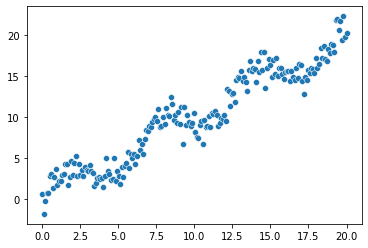

In [6]:
X = np.linspace(0,20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape) # linear + nonliner + random part

sns.scatterplot(x=X, y=y)

As a reminder: To create a ``Dataset`` object, we need to define the magic methots ``__len__``, ``__getindex__`` and the constructor ``__init__``.
The ``Dataset`` object controlls how to get a specific datapoint. The ``DataLoader`` optimizes the datapipeline in such a way that the GPU is as busy as possible during training. Hence, the dataloader fetches the data from the dataset.

In addition, we are reshaping the numpy array when it reaches the system with the command `.reshape(-1,1)`. This simply means, that the first dimension should be infered from the input length. In addition, a second dimension of size 1 is added.
For a more detailed explanation, see the book on side 38.
`reshape()` works in the way that is simply reshapes a given data structure. For this, we need to specify all but one dimension, where the left over dimension (we don't want to specify) is denoted with '-1'. By adding more arguments to the function, we add more dimensions to the tensor. 

*Example:* Given a numpy array x of 6 values with only one dimension, we can use ``x.reshape(6)`` or ``x.reshape(-1)`` to get the same value. When using ``x.reshape(-1,3)`` We say that the second dimension (width of tensor) should be 3 and due to '-1' numpy infers that the height of the 2d tensor should be 2.


In [18]:
class regressionDataset(Dataset):
    def __init__(self,X,y):
        super(regressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        "This magic method returns a sample and the label for the given index. The returned values must be a torch.tensor"
        input = torch.tensor(self.X[index,:], dtype=torch.float32)
        label = torch.tensor(self.y[index], dtype=torch.float32)
        return input, label
    
    def __len__(self):
        "Returns number of samples"
        return self.X.shape[0]

In [19]:
data = regressionDataset(X,y)
print(len(data)) # works
print(data[2]) # works

200
(tensor([0.2010]), tensor([-0.2805]))


The created dataset can now be used by a ``DataLoader``. The dataloader makes passing data to the model more efficient and hence is the preferred way for training.

In [21]:
training_loader = DataLoader(regressionDataset(X,y), shuffle=True)

Now, we have created the needed data and can create and train our model. Therefore, we will use a simple linear layer which corresponds to a vector matrix multiplication of the input, wehereas the weights correspond to the coefficients. In addition, a bias term is added, which allows the model to shift the solution.

In pytorch, the building blocks are defined in modules such as ``torch.nn.Linear``.
Each module has a ``forward()`` method which defines how data passes through the layer (i.e. takes input and produces output) and also a ``backward()`` method which defines how the gradient is calculated. Usually, pytorch takes care of the latter one.

Regarding the loss: The absolute difference is taken, to omit a negative loss, which would lead the model to get worse since a negative loss would further decrease the loss (loss function should be bounded from below by 0). An alternative would be the MSE.


In [23]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = torch.device("cuda")
train_simple_network(model, loss_func,training_loader,20, device="cpu")
# stopped at 2.1.7 (end of page 41)

Epoch: 100%|██████████| 20/20 [00:00<00:00, 20.35it/s]
